### Imports

In [130]:
# --- Imports ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [131]:
import os
import random
import numpy as np
import tensorflow as tf

SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### CNN Build

In [132]:
def build_paper_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(32, kernel_size=8, strides=1, activation='relu', padding="valid"),
        MaxPooling1D(pool_size=2, strides=2),
        Flatten(),  
        Dense(128, activation='relu'),
        Dropout(0.068),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.008), loss='binary_crossentropy', metrics=['accuracy'])
    return model


### Load Data 

In [133]:
def load_and_prepare_data(variant):
    base_path = Path("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/data_splits")
    path = base_path / variant

    X_train = pd.read_csv(path / "X_train.csv", index_col=0)
    X_test  = pd.read_csv(path / "X_test.csv", index_col=0)
    y_train = pd.read_csv(path / "y_train.csv", index_col=0).squeeze()
    y_test  = pd.read_csv(path / "y_test.csv", index_col=0).squeeze()

    # 50/50 split of test set into validation and final test
    X_val, X_test_final, y_val, y_test_final = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
    )

    # Add channel dimension for Conv1D
    X_train_cnn = X_train.values[..., np.newaxis]
    X_val_cnn   = X_val.values[..., np.newaxis]
    X_test_cnn  = X_test_final.values[..., np.newaxis]

    return X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test_final


### Train & Eval CNN

In [134]:
def train_and_evaluate_cnn(X_train, y_train, X_val, y_val, X_test, y_test, variant):
    model = build_paper_cnn(input_shape=X_train.shape[1:])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train with val split from test
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate on test-final split
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

    print(f"\nFinal Test Results for {variant}")
    print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - Final Test ({variant})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return round(accuracy_score(y_test, y_pred), 4)


### Run 

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5221 - loss: 33.1983 - val_accuracy: 0.6863 - val_loss: 14.0384
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7055 - loss: 10.1269 - val_accuracy: 0.5686 - val_loss: 3.4712
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7235 - loss: 1.3660 - val_accuracy: 0.4902 - val_loss: 1.1495
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6493 - loss: 0.7471 - val_accuracy: 0.6863 - val_loss: 0.6707
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8292 - loss: 0.4538 - val_accuracy: 0.7255 - val_loss: 0.5197
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8324 - loss: 0.3833 - val_accuracy: 0.7255 - val_loss: 0.5763
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8849 - loss: 0.3126 - val_accuracy: 0.7647 - val_loss: 0.5857
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9290 - loss: 0.2033 - val_accuracy: 0.7451 - val_loss: 0.55

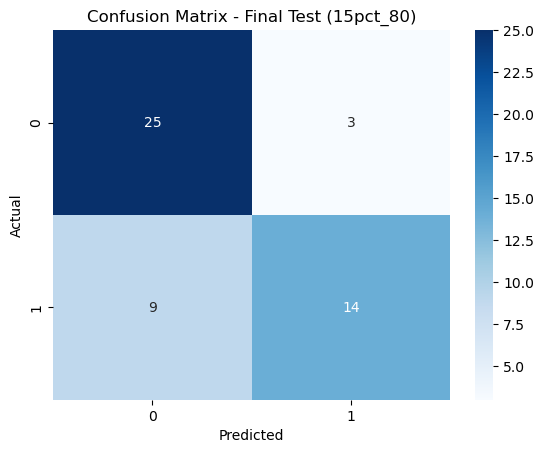

Final test accuracy: 0.7647


In [135]:
variant = "15pct_80"

X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test_final = load_and_prepare_data(variant)
final_acc = train_and_evaluate_cnn(X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test_final, variant)
print("Final test accuracy:", final_acc)


### Hyperparam tuning

In [136]:
# def build_cnn_for_tuning(input_shape=(512, 1), filters=32, kernel_size=50, dense_units=64, dropout=0.1, learning_rate=0.001):
#     model = Sequential([
#         Input(shape=input_shape),
#         Conv1D(filters, kernel_size=kernel_size, activation='relu'),
#         MaxPooling1D(pool_size=2),
#         Flatten(),
#         Dense(dense_units, activation='relu'),
#         Dropout(dropout),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

In [137]:
# def load_tuning_data(variant):
#     path = Path("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/data_splits") / variant
#     X_train = pd.read_csv(path / "X_train.csv", index_col=0)
#     y_train = pd.read_csv(path / "y_train.csv", index_col=0).squeeze()
#     X_test  = pd.read_csv(path / "X_test.csv", index_col=0)
#     y_test  = pd.read_csv(path / "y_test.csv", index_col=0).squeeze()

#     # Combine all into one (train + test) for grid search CV
#     X_full = pd.concat([X_train, X_test]).values[..., np.newaxis]
#     y_full = pd.concat([y_train, y_test])

#     return X_full, y_full, X_train.shape[1]


In [138]:
# from sklearn.model_selection import StratifiedKFold, GridSearchCV

# variant = "15pct_80"
# X, y, input_dim = load_tuning_data(variant)

# model = KerasClassifier(
#     model=build_cnn_for_tuning,
#     input_shape=(input_dim, 1),
#     verbose=0,
#     random_state=SEED 
# )

# param_grid = {
#     "model__filters": [16, 32, 64],
#     "model__kernel_size": [10, 25, 50],
#     "model__dense_units": [32, 64, 128],
#     "model__dropout": [0.1, 0.3],
#     "model__learning_rate": [0.001, 0.01],
#     "batch_size": [32, 64],
#     "epochs": [30],
# }

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# grid = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='accuracy',
#     n_jobs=-1
# )

# grid.fit(X, y)

# print("Best score:", grid.best_score_)
# print("Best params:", grid.best_params_)


In [139]:
# )

# grid.fit(X, y)

# print("✅ Best score:", grid.best_score_)
# print("✅ Best params:", grid.best_params_)


In [140]:
# X_train.shape[1:]